### Import libraries

In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

### Set Up GPUs

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Parameters

In [119]:
episodes = 500
gamma = 0.95 # specified by homework

# network parameters
learning_rate = 0.01
hidden_size = 10

### Policy Gradient Network

In [120]:
class PolicyGradient():
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='PolicyGradient'):
        with tf.variable_scope(name):
            
            # Store Variables
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None, action_size], name='actions')
            self.expected_future_rewards_ = tf.placeholder(tf.float32, [None,], name="expected_future_rewards")
            
            # Hidden Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, action_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            
            # Output Layer
            self.action_distribution = tf.nn.softmax(self.fc3)
            
            # Training Section
            self.log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.fc3, labels = self.actions_)
            self.loss = tf.reduce_mean(self.log_prob * self.expected_future_rewards_)

            # Adjust Network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### Baseline Network

In [121]:
class Baseline():
    def __init__(self, learning_rate=0.01, state_size=4, hidden_size=10, name="Baseline"):
        with tf.variable_scope(name):

            # Store Variables
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.expected_future_rewards_ = tf.placeholder(tf.float32, [None,], name="expected_future_rewards")

            # Hidden Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 1, activation_fn=None, 
                                                                 weights_initializer=tf.contrib.layers.xavier_initializer())

            # Define Loss
            self.loss = tf.reduce_mean(tf.square(self.fc3 - self.expected_future_rewards_), name="mse")

            # Adjust Network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### Setup

In [122]:
tf.reset_default_graph()
network = PolicyGradient(name = 'pray4us', hidden_size=hidden_size, learning_rate=learning_rate)
baseline = Baseline(name = 'ughvariance', hidden_size=hidden_size, learning_rate=learning_rate)

In [123]:
# set up environment
env = gym.make('CartPole-v0')

# Initialize the simulation
env.reset()

array([ 0.04894395,  0.04782548, -0.02405463,  0.04536459])

### Predict Future Reward Function

In [124]:
def expected_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)
    
    return discounted_episode_rewards.tolist()

### Training

In [128]:
# saver = tf.train.Saver()
all_rewards = []

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())   
    for ep in range(episodes):
        
        state = env.reset()
        episode_rewards = []
        
        # save all states, actions, and rewards that happen 
        episode_states, episode_actions, episode_rewards = [], [], []
        
        while True: 
        
            # get action prob distribution w.r.t. policy
            feed = {network.inputs_: state.reshape((1,*state.shape))}
            action_prob_dist = sess.run(network.action_distribution, feed_dict=feed)
            
            # select action w.r.t. distribution
            action = np.random.choice(range(action_prob_dist.shape[1]), p=action_prob_dist.ravel())
            new_state, reward, done, _ = env.step(action)
            
            # keep track of all states, actions, and rewards
            episode_states.append(state)
            episode_rewards.append(reward)
            
            # reformat action for softmax
            action_ = np.zeros(action_prob_dist.shape[1])
            action_[action] = 1
            episode_actions.append(action_)
            
            # reset current state to be new state
            state = new_state
            
            if done:
                # calculate discounted reward per episode
                exp_rewards = expected_rewards(episode_rewards)
                all_rewards.append(sum(episode_rewards))
                
                # get baseline adjustment
                baseline_ = sess.run(baseline.fc3, feed_dict={baseline.inputs_ : np.vstack(episode_states)})
                exp_rewards_b = exp_rewards - np.hstack(baseline_)
                
                # train baseline network
                _, _= sess.run([baseline.loss, baseline.learn], 
                            feed_dict={baseline.inputs_: np.vstack(episode_states),
                            baseline.expected_future_rewards_: exp_rewards })
                
                # train Policy Gradient Network
                _, _= sess.run([network.loss, network.learn], 
                                            feed_dict={network.inputs_: np.vstack(episode_states),
                                            network.actions_: np.vstack(episode_actions),
                                            network.expected_future_rewards_: exp_rewards_b })
                
                break
#         if (epoch % 100 == 0):
#             saver.save(sess, "checkpoints/cartpole{0}.ckpt".format(epoch))
            

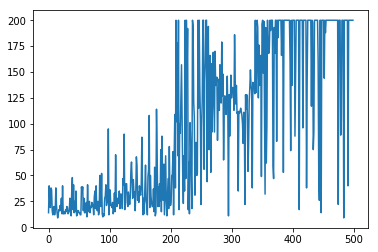

In [129]:
# no baseline
plt.plot(all_rewards)

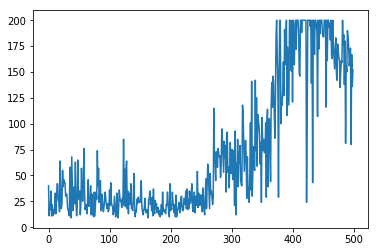

In [127]:
# BASELINE COMPARISON
plt.plot(all_rewards)

In [ ]:
### QUESTIONS ABOUT BASELINE